In [21]:
%pylab inline
%matplotlib inline
pylab.rcParams['figure.figsize'] = (16, 9)

# numpy, matplotib and others
import numpy as np
from numpy.random import RandomState
from numpy.linalg import cholesky
import matplotlib.pyplot as plt
import os
import pickle

# L63 and L96 models using python (slow)
from models.L63 import l63_predict, l63_jac
from models.L96 import l96_predict, l96_f

# data assimilation routines
from algos.utils import climat_background, RMSE, gen_truth, gen_obs

Populating the interactive namespace from numpy and matplotlib


In [22]:
### GENERATE SIMULATED DATA (LORENZ-63 MODEL)

# random number generator
prng = RandomState(9)

# dynamical model
Nx = 3 # dimension of the state
dt = .01 # integration time
sigma = 10;rho = 28;beta = 8./3 # physical parameters
f = lambda x: l63_predict(x, dt, sigma, rho, beta) # python version (slow)
#fmdl=mdl_l63.M(sigma=sigma, rho=rho, beta=beta, dtcy=dt)
#f = lambda x: fmdl.integ(x) # fortran version (fast)
jacF = lambda x: l63_jac(x, dt, sigma, rho, beta) # python version (slow)

# observation operator
No = 3 # dimension of the observations
h = lambda x: x
jacH = lambda x: np.eye(Nx)
H = np.eye(Nx)

# background state
x0_true = np.r_[6.39435776, 9.23172442, 19.15323224]
xb, B = climat_background(f, x0_true, 5000)

# size of the sequence
T = 1000 # 10 Lorenz-63 times
time = range(T)*array([dt])

# generate state
Q_true = np.eye(Nx) * .05
X_true = gen_truth(f, x0_true, T, Q_true, prng)

# generate observations
dt_obs = 1 # 1 observation every dt_obs time steps
R_true = np.eye(No) * 2
Yo = gen_obs(h, X_true, R_true, dt_obs, prng)

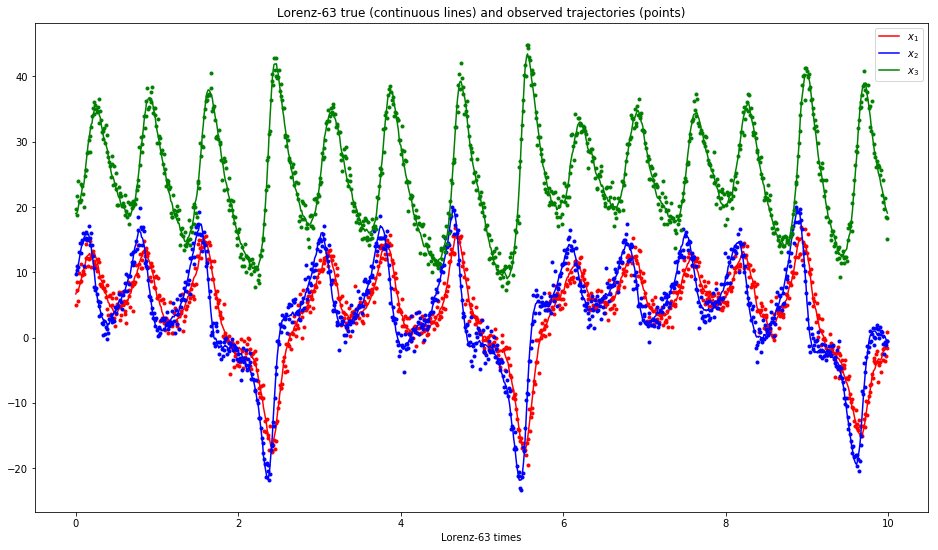

In [23]:
### PLOT STATE AND OBSERVATIONS

line1,=plt.plot(time,X_true[0,1:T+1],'-r');plt.plot(time,Yo[0,:],'.r')
line2,=plt.plot(time,X_true[1,1:T+1],'-b');plt.plot(time,Yo[1,:],'.b')
line3,=plt.plot(time,X_true[2,1:T+1],'-g');plt.plot(time,Yo[2,:],'.g')
plt.title('Lorenz-63 true (continuous lines) and observed trajectories (points)')
plt.xlabel('Lorenz-63 times')
plt.legend([line1, line2, line3], ['$x_1$', '$x_2$', '$x_3$'])

In [24]:
### INITIALIZE THE ALGORITHMS

# EM parameters
N_iter = 500
Q_init = np.eye(Nx)
R_init = np.eye(No)
N = 100 # number of members (only in EM-EnKS)

In [50]:
### KALMAN FILTER

def _EKF(Nx, No, T, xb, B, Q, R, Yo, f, jacF, h, jacH, alpha):
    Xa = np.zeros((Nx, T+1))
    Xf = np.zeros((Nx, T))
    Pa = np.zeros((Nx, Nx, T+1))
    Pf = np.zeros((Nx, Nx, T))
    F_all = np.zeros((Nx, Nx, T))
    H_all = np.zeros((No, Nx, T))
    K_all = np.zeros((Nx, No, T+1))
    d_all = np.zeros((No, T))
    
    x = xb; Xa[:,0] = x
    P = B; Pa[:,:,0] = P
    for t in range(T):
    # Forecast
        F = jacF(x)
        x = f(x)                    # Paper --> xf(k+1) = F(k)xa(k)
        P = F.dot(P).dot(F.T) + Q   # Paper --> Pf(k_1) = F(k)Pa(k)HT(k+1)+Qfilt(k)
        P = .5*(P + P.T)            # Not in the Paper --> ???averaging???

        Pf[:,:,t]=P; Xf[:,t]=x; F_all[:,:,t]=F  # assigning to time sampled variables in paper t --> t+1

    # Update
        if not np.isnan(Yo[0,t]):
            H = jacH(x)                        # linear function of y update
            d = Yo[:,t] - h(x)                 # Paper --> y(k+1) - yf(k+1)
            S = H.dot(P).dot(H.T) + R/alpha    # Paper --> Py(k+1) = H(k+1)Pf(k+1)HT(k+1) + Rfilt(k)
            K = P.dot(H.T).dot(inv(S))         # Paper --> K(k+1) = Pf(k+1)HT(k+1)(Py(k+1))^-1
            P = (np.eye(Nx) - K.dot(H)).dot(P) # Paper --> Pa(k+1) = (I-K(k+1)H(k+1))Pf(k+1)
            x = x + K.dot(d)                   # Paper --> xa(k+1) = x(f)(k+1) + K(k+1)(innovation)
    
        Pa[:,:,t+1]=P; Xa[:,t+1]=x; H_all[:,:,t]=H
        d_all[:,t]=d; K_all[:,:,t+1]=K
        
        
    Qe_all = np.zeros((Nx, Nx, T))
    Re_all = np.zeros((No, No, T))
        
    Q_filt = np.zeros((Nx, Nx, T))
    R_filt = np.zeros((No, No, T))
    
    delta = 1/2000
    
    for t in range(1,T-1):
        Pe_1 = inv((H_all[:,:,t+1].dot(F_all[:,:,t])))
        Pe_2 = d_all[:,t+1].dot(d_all[:,t].T)+H_all[:,:,t+1].dot(F_all[:,:,t]).dot(K_all[:,:,t]).dot(d_all[:,t]).dot(d_all[:,t].T)
        Pe = inv(Pe_1).dot(Pe_2).dot(inv(H_all[:,:,t].T))
        
        Qe = Pe - F_all[:,:,t-1].dot(Pa[:,:,t-1]).dot(F_all[:,:,t-1].T)
        
        Re = d_all[:,t].dot(d_all[:,t].T) - H_all[:,:,t].dot(Pf[:,:,t]).dot(H_all[:,:,t].T)
        
        Qe_all[:,:,t] = Qe
        Re_all[:,:,t] = Re
        
        Q_filt[:,:,t] = Q_filt[:,:,t-1] + delta*(Qe-Q_filt[:,:,t-1])
        R_filt[:,:,t] = R_filt[:,:,t-1] + delta*(Re-R_filt[:,:,t-1])
    
    print(Q_filt[:,:,998])
    print(R_filt[:,:,998])
    
    
    
    
    res = {
          'analysis_states'            : Xa,
          'analysis_covariance'        : Pa,
          'forecast_states'            : Xf,
          'forecast_covariance'        : Pf,
          'state_linearisation'        : F_all,
          'forecast_linearisation'     : H_all,
          'kalman_gain'                : K_all,
          'model_noise_covariance'     : Qe_all,
          'observarion_covariance'     : Re_all,
          'model_noise_covariance_filt': Q_filt,
          'observarion_covariance_filt': R_filt
        }
    
    return res

In [52]:
### APPLY THE EM ALGORITHM ON EXTENDED KALMAN SMOOTHER (EM-EKS)

# parameters
params = { 'initial_background_state'                 : xb,
           'initial_background_covariance'            : B,
           'initial_model_noise_covariance'           : Q_init,
           'initial_observation_noise_covariance'     : R_init,
           'model_dynamics'                           : f,
           'model_jacobian'                           : jacF,
           'observation_operator'                     : h,
           'observation_jacobian'                     : jacH,
           'observations'                             : Yo,
           'nb_EM_iterations'                         : N_iter,
           'true_state'                               : X_true,
           'state_size'                               : Nx,
           'observation_size'                         : No,
           'temporal_window_size'                     : T,
           'model_noise_covariance_structure'         : 'full',
           'is_model_noise_covariance_estimated'      : True,
           'is_observation_noise_covariance_estimated': True,
           'is_background_estimated'                  : True,
           'inflation_factor'                         : 1 
         }

# function
res_EKF = _EKF(Nx, No, T, xb, B, Q_init, R_init, Yo, f, jacF, h, jacH, 1)
#res_EM_EKS = EM_EKS(params)

[[ 1.69411835  0.14099647 -0.02062066]
 [-0.02455091  1.79594315 -0.08217759]
 [ 0.06215469  0.08127266  1.77991114]]
[[5.9560032  7.16812983 7.2253486 ]
 [7.16812983 5.85036297 7.24544263]
 [7.2253486  7.24544263 5.87009197]]


Text(0.5,0,'Lorenz-63 times')

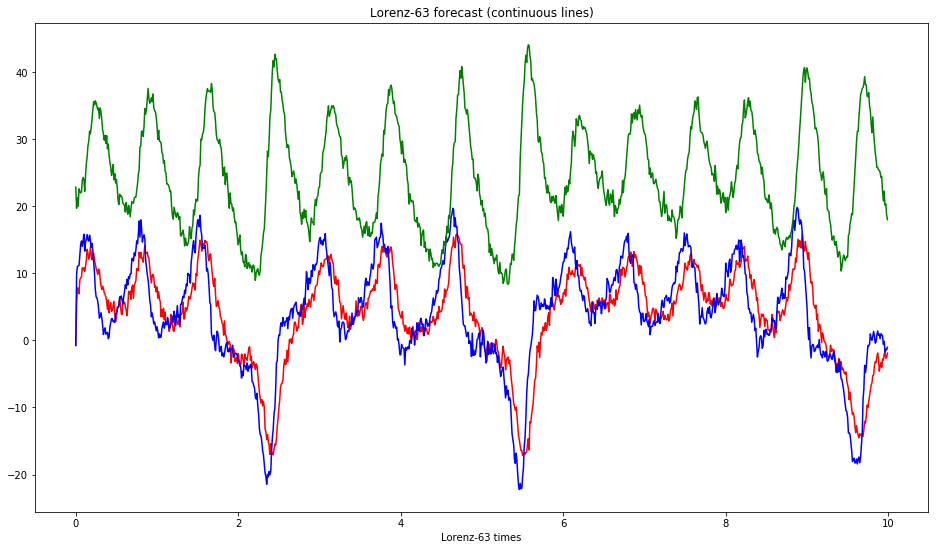

In [54]:
Xf = res_EKF['forecast_states']

line1=plt.plot(time,Xf[0,:],'-r')
line2=plt.plot(time,Xf[1,:],'-b')
line3=plt.plot(time,Xf[2,:],'-g')
plt.title('Lorenz-63 forecast (continuous lines)')
plt.xlabel('Lorenz-63 times')
#plt.legend([line1, line2, line3], ['$x_1$', '$x_2$', '$x_3$'])

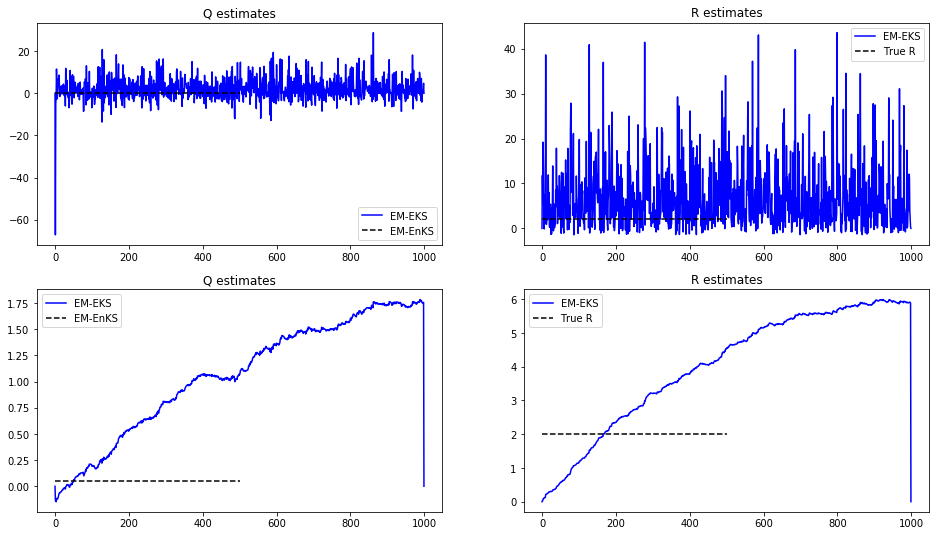

In [57]:
### COMPARE RESULTS BETWEEN THE TWO STRATEGIES (EM-EKS AND EM-EnKS)

# extract outputs
Q_e = res_EKF['model_noise_covariance']
R_e = res_EKF['observarion_covariance']


Q_filt = res_EKF['model_noise_covariance_filt']
R_filt = res_EKF['observarion_covariance_filt']

# plot trace of Q
plt.subplot(2,2,1)
line1,=plt.plot(np.trace(Q_e)/Nx,'b')
line3,=plt.plot((1,N_iter),(np.trace(Q_true)/Nx,np.trace(Q_true)/Nx),'--k')
plt.title('Q estimates')
plt.legend([line1, line3], ['EM-EKS', 'EM-EnKS', 'True Q'])

# plot trace of R
plt.subplot(2,2,2)
line1,=plt.plot(np.trace(R_e)/No,'b')
line3,=plt.plot((1,N_iter),(np.trace(R_true)/No,np.trace(R_true)/No),'--k')
plt.title('R estimates')
plt.legend([line1, line3], ['EM-EKS', 'True R'])


# plot trace of Q
plt.subplot(2,2,3)
line1,=plt.plot(np.trace(Q_filt)/Nx,'b')
line3,=plt.plot((1,N_iter),(np.trace(Q_true)/Nx,np.trace(Q_true)/Nx),'--k')
plt.title('Q estimates')
plt.legend([line1, line3], ['EM-EKS', 'EM-EnKS', 'True Q'])

# plot trace of R
plt.subplot(2,2,4)
line1,=plt.plot(np.trace(R_filt)/No,'b')
line3,=plt.plot((1,N_iter),(np.trace(R_true)/No,np.trace(R_true)/No),'--k')
plt.title('R estimates')
plt.legend([line1, line3], ['EM-EKS', 'True R'])

